In [1]:
from torch_geometric.data import Data, Batch, DataLoader
import torch
from scipy.io import loadmat
from torchvision.datasets.utils import download_url
import matplotlib.pyplot as plt
import numpy as np
import time
from os import path
# add directory above current directory to path
import sys
sys.path.insert(0, '..')

# Parameters

In [2]:
DATASET_NAME = "INDIAN_PINES"
ADD_POSITION_TO_FEATURES = True
DESIRED_NEIGHBOURHOOD = 10

## Load hyperspectral image dataset

In [3]:
print("Reading dataset...")

if DATASET_NAME == "INDIAN_PINES":
    url = 'http://www.ehu.eus/ccwintco/uploads/2/22/Indian_pines.mat'
    gt_url = 'http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat'
    mat_key = 'indian_pines'
    gt_mat_key = 'indian_pines_gt'
    
elif DATASET_NAME == "SALINAS":
    url = 'http://www.ehu.eus/ccwintco/uploads/a/a3/Salinas_corrected.mat'
    gt_url = 'http://www.ehu.eus/ccwintco/uploads/f/fa/Salinas_gt.mat'
    mat_key = 'salinas_corrected'
    gt_mat_key = 'salinas_gt'
    
elif DATASET_NAME == "PAVIA_UNIVERSITY":
    url = 'http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat'
    gt_url = 'http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat'
    mat_key = 'pavia_university'
    gt_mat_key = 'pavia_university_gt'

elif DATASET_NAME == "KENNEDY_SPACE_CENTER":
    url = 'http://www.ehu.es/ccwintco/uploads/2/26/KSC.mat'
    gt_url = 'http://www.ehu.es/ccwintco/uploads/a/a6/KSC_gt.mat'
    mat_key = 'kennedy_space_center'
    gt_mat_key = 'kennedy_space_center_gt'
else:
    raise  Exception("Incorrect dataset name!")

dir_path = f'../data/{DATASET_NAME}'
data_filename = f'{DATASET_NAME}.mat'
gt_filename = f'{DATASET_NAME}_gt.mat'
if not path.exists(dir_path):
    download_url(url, dir_path, data_filename)
    download_url(gt_url, dir_path, gt_filename)


data_mat = loadmat(path.join(dir_path, data_filename))
gt_mat = loadmat(path.join(dir_path, gt_filename))

data = data_mat[mat_key]
gt = gt_mat[gt_mat_key]

print("Done.")

Reading dataset...
Done.


In [4]:
print(data.shape)
print(gt.shape)
assert DESIRED_NEIGHBOURHOOD > 1, ('the neighbohood size cannot be too small')

(145, 145, 220)
(145, 145)


## Show one band

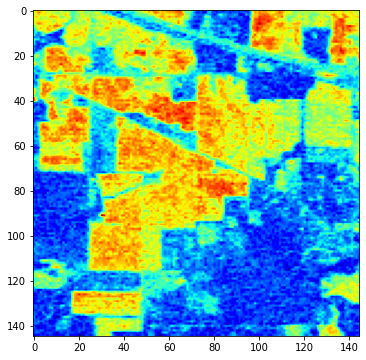

In [5]:
test_img = data[:, :, data.shape[-1]//2]
plt.figure(figsize=(8, 6))
plt.imshow(test_img, cmap='jet')
plt.show()

## Plot ground truth

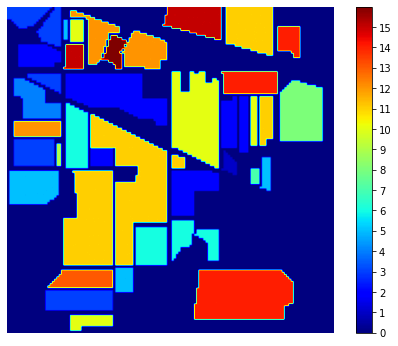

In [6]:
plt.figure(figsize=(8, 6))
plt.imshow(gt, cmap='jet')
plt.axis('off')
plt.colorbar(ticks= range(0,16))
plt.show()

## Extract pixels

In [7]:
pixels = data.reshape(data.shape[0] * data.shape[1], data.shape[2])
pixels_gt = gt.ravel()
pixels_gt = pixels_gt[pixels_gt != 0]
filtered_pixels = pixels[pixels_gt]
filtered_pixels.shape

(10249, 220)

## Run KNN

In [8]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=DESIRED_NEIGHBOURHOOD)
neigh.fit(filtered_pixels)
neighbours = neigh.kneighbors(filtered_pixels)[1]
neighbours.shape

(10249, 10)

## Convert pixels to graph dataset

In [9]:
import multiprocessing
from itertools import repeat

print("Processing pixels into graphs...")
ptime = time.time()

num_of_nodes = filtered_pixels.shape[0]
num_of_features = filtered_pixels.shape[1]
n = neighbours.shape[0] * neighbours.shape[1]

x = np.zeros([num_of_nodes, num_of_features]).astype(np.float32)
y = np.zeros(num_of_nodes).astype(np.int64)
edge_index = []

for index, (pixel, gt, neigh) in enumerate(zip(filtered_pixels, pixels_gt, neighbours)):
    x[index] = pixel
    y[index] = gt
    
    edges = list(zip(repeat(index), neigh)) + list(zip(neigh, repeat(index)))
    edge_index.extend(edges)
    

x_tensor = torch.as_tensor(x, dtype=torch.long)
edge_index_tensor = torch.as_tensor(edge_index, dtype=torch.long).t().contiguous()
y_tensor = torch.as_tensor(y, dtype=torch.long)

slices = {
    "x": x_tensor,
    "edge_index": edge_index_tensor,
    "y": y_tensor,
}
            

ptime = time.time() - ptime
print(f"Took {ptime}s.")

Processing pixels into graphs...
Took 0.18230128288269043s.


In [10]:
print(x_tensor.shape)
print(edge_index_tensor.shape)
print(y_tensor.shape)

torch.Size([10249, 220])
torch.Size([2, 204980])
torch.Size([10249])


In [11]:
data = Data(x=x_tensor, edge_index=edge_index_tensor, y=y_tensor)
print(data)

Data(edge_index=[2, 204980], x=[10249, 220], y=[10249])


## Save dataset in PyTorch Geometric format

In [12]:
import os

path = "../data/" + DATASET_NAME + "_hs_" + str(DESIRED_NEIGHBOURHOOD) + "/" + "processed" + "/"
if not os.path.exists(path):
    os.makedirs(path)

torch.save((data, slices), path + "data.pt")